In [44]:
# Install this, for some reason, google colab doesn't have this on their dependencies.
!pip install pylint

# Imports

In [45]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate, GlobalMaxPooling1D, BatchNormalization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import re
from io import BytesIO
from tokenize import tokenize, COMMENT, NL
import pickle
import pylint
import subprocess
import os
import tempfile
import timeit
import sys
import ast

# Dataset for Code Readability

https://www.kaggle.com/datasets/paakhim10/code-snippets-insights-and-readability

In [137]:
# load original dataset that was gathered for Phaaki
df_temp = pd.read_csv('data_python.csv')

# remove other non-needed columns
df_temp = df_temp[['python_solutions', 'readability']]

# change readability to binary
df_temp['label'] = (df_temp['readability'] > 2.4).astype(int) #2.4 as the most reasonable threshold

# remove main readability column
df_temp = df_temp[['python_solutions', 'label']]

# extract python codes "python_solution" and labels
code_snippets = df_temp['python_solutions'].astype(str).tolist()
labels = df_temp['label'].values

# export incomplete data for code generating
fixed_file_path = "data_python_incomplete.csv"
df_temp.to_csv(fixed_file_path, index=False)

After, export the "data_python_incomplete" and insert in the code generator.
https://colab.research.google.com/drive/1EqmokAWMewjHJKkUu4wYmFfRW8vaT_VS?usp=sharing

### Import the Python Complete from Code Generator

In [139]:
# load complete data
df = pd.read_csv('data_python_complete.csv')

# keep important columns
df = df[['python_solutions', 'label']]

# check if labels are 0 and 1
df['label'] = df['label'].astype(int)

# extract python codes and labels
pycode = df['python_solutions'].astype(str).tolist()
labels = df['label'].values

In [140]:
df.head()

,python_solutions,label
0,"class Solution:\n def twoSum(self, nums: Li...",1
1,class Solution:\n def lengthOfLongestSubstr...,1
2,class Solution:\n def findMedianSortedArray...,1
3,class Solution:\n def longestPalindrome(sel...,1
4,"class Solution:\n def convert(self, s: str,...",1


### Data Checking without Tokenization

label
1    1312
0    1000
Name: count, dtype: int64


<Axes: title={'center': 'Class Distribution'}, xlabel='label'>

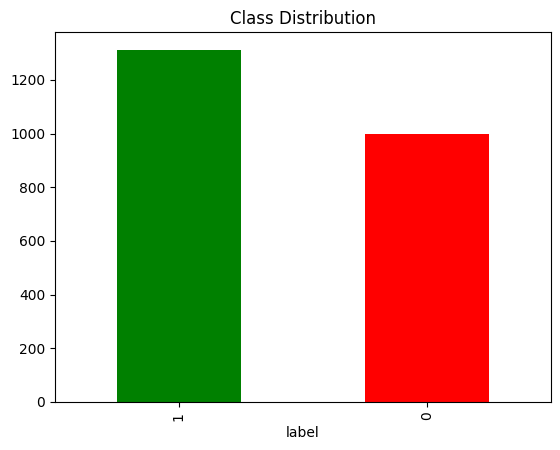

In [142]:
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='bar', title="Class Distribution", color=['green', 'red'])

###  Tokenization

In [143]:
def clean_python_code(code):
    if not isinstance(code, str) or len(code.strip()) == 0:
        return "EMPTY_CODE"

    code = code.replace('\t', '    ')
    code = re.sub(r'#.*', '', code)
    code = re.sub(r'""".*?"""|\'\'\'.*?\'\'\'', '', code, flags=re.DOTALL)
    code = re.sub(r'(\b(if|for|while|def|class)\b[^\n]*)(?<!:)\n', r'\1:\n', code)
    code = re.sub(r'(\b(def|class)\b[^\n]*:)(\n\s*\n)', r'\1\n    pass\n', code)

    code = re.sub(r'\s*([,:\])}])', r'\1', code)
    code = re.sub(r'([{[(])\s*', r'\1', code)

    return code.strip()

# apply function to dataset muna
df['clean_python_solutions'] = df['python_solutions'].apply(clean_python_code)

df = df.drop_duplicates(subset=['clean_python_solutions'], keep='first')
df = df[df['clean_python_solutions'] != "EMPTY_CODE"]
df = df.reset_index(drop=True)
df['clean_python_solutions'] = df['python_solutions'].apply(clean_python_code)

In [145]:
print(df[['python_solutions', 'clean_python_solutions']].head(10))

                                    python_solutions  \
0  class Solution:\n    def twoSum(self, nums: Li...   
1  class Solution:\n    def lengthOfLongestSubstr...   
2  class Solution:\n    def findMedianSortedArray...   
3  class Solution:\n    def longestPalindrome(sel...   
4  class Solution:\n    def convert(self, s: str,...   
5  class Solution:\n    def reverse(self, x: int)...   
6  class Solution:\n    def myAtoi(self, s: str) ...   
7  class Solution:\n    def isPalindrome(self, x:...   
8  class Solution:\n    @lru_cache\n    def isMat...   
9  class Solution:\n    def maxArea(self, height:...   

                              clean_python_solutions  
0  class Solution:\n    def twoSum(self, nums: Li...  
1  class Solution:\n    def lengthOfLongestSubstr...  
2  class Solution:\n    def findMedianSortedArray...  
3  class Solution:\n    def longestPalindrome(sel...  
4  class Solution:\n    def convert(self, s: str,...  
5  class Solution:\n    def reverse(self, x: int)... 

### Data Checking with Tokenization

label
1    1312
0    1000
Name: count, dtype: int64


<Axes: title={'center': 'Label Pie'}, ylabel='count'>

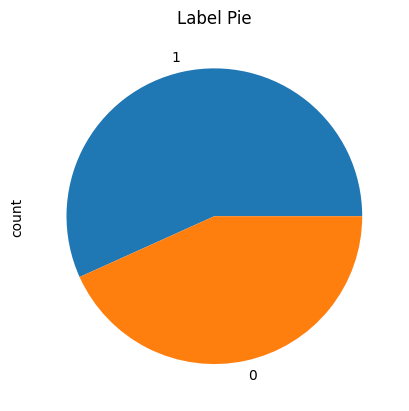

In [146]:
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='pie', title="Label Pie")

### More Tokenizing

In [147]:
# Tokenize
max_vocab_size = 5000
max_length = 500

tokenizer = Tokenizer(num_words=max_vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(df['clean_python_solutions'])
sequences = tokenizer.texts_to_sequences(df['clean_python_solutions'])

X = pad_sequences(sequences, maxlen=max_length, padding='post')
X_train, X_test, y_train, y_test = train_test_split(X, df['label'].values, test_size=0.2, random_state=42)

### Last Checking of Data with Finalized Tokenizing

label
1    1312
0    1000
Name: count, dtype: int64


<Axes: title={'center': 'Final Label Pie'}, ylabel='count'>

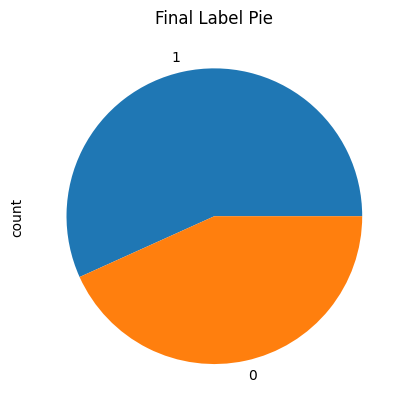

In [148]:
print(df['label'].value_counts())
df['label'].value_counts().plot(kind='pie', title="Final Label Pie")

### Creating the CNN Model for Code Readability

This one is important because it is needed said in the instructions

In [149]:
def create_cnn_model(filters=32):# increase filter by 64 of 16 for tweaking
    inputs = Input(shape=(max_length,), name='cnn_input')
    x = Embedding(input_dim=max_vocab_size, output_dim=128, input_length=max_length)(inputs)
    x = Conv1D(filters=filters, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=filters * 2, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)

    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)# increase L2 for tweaking
    x = Dropout(0.4)(x)# increase or decrease dropout for tweaking
    output_layer = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=output_layer)
    return model

# creating the model
model = create_cnn_model()

# Adam Optimizer with Exponential Decay
lr_schedule = ExponentialDecay(initial_learning_rate=0.0003, decay_steps=1000, decay_rate=0.9)
optimizer = Adam(learning_rate=lr_schedule)

# compiling
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [150]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ cnn_input (InputLayer)               │ (None, 500)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 500, 128)            │         640,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 498, 32)             │          12,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 249, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 247, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 123, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 7872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,007,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,666,401 (6.36 MB)

 Trainable params: 1,666,401 (6.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the Code Readability

In [151]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
print(df['label'].value_counts())

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

print("Class Weights:", class_weight_dict)

history = model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping],
    class_weight=class_weight_dict
)

model.save("CRModel.keras")

label
1    1312
0    1000
Name: count, dtype: int64
Class Weights: {0: 1.1628930817610064, 1: 0.877134724857685}
Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.6764 - loss: 2.3349 - val_accuracy: 0.8877 - val_loss: 0.6214
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 97ms/step - accuracy: 0.8676 - loss: 0.5972 - val_accuracy: 0.8985 - val_loss: 0.3501
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.8956 - loss: 0.3730 - val_accuracy: 0.9222 - val_loss: 0.2970
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.9057 - loss: 0.3052 - val_accuracy: 0.9093 - val_loss: 0.2820
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - accuracy: 0.9220 - loss: 0.2710 - val_accuracy: 0.9028 - val_loss: 0.2816
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 81ms/step - accuracy: 0.9360 - loss: 0.2143 - val_accuracy: 0.9136 - val_loss: 0.2989
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.9434 - loss: 0.1912 - val_accuracy: 0.9028 - val_loss: 0.

### Tokenizer saving

In [152]:
# Save the tokenizer to a file
tokenizer_path = "/content/python_tokenizer.pkl"  # Colab
with open(tokenizer_path, "wb") as handle:
    pickle.dump(tokenizer, handle)

print(f"Tokenizer saved at {tokenizer_path}")

Tokenizer saved at /content/python_tokenizer.pkl


### Accuracy Checking

In [153]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(X_test, y_test)

# Print final accuracy and loss
print(f"\nFinal Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8979 - loss: 0.2966

Final Test Accuracy: 0.9028
Final Test Loss: 0.2816


### Data Checking for Readable data and Predicted data

In [154]:
#Readable data
actual_readable = (df['label'] == 1).sum()
actual_unreadable = (df['label'] == 0).sum()
print(f"Actual Readable: {actual_readable}/{len(df)}")
print(f"Actual Unreadable: {actual_unreadable}/{len(df)}")

# Get predictions for ALL data, not just X_test
predictions = model.predict(X)  # Use full dataset `X`

# Convert predictions to binary (readable/unreadable)
pred_labels = (predictions > 0.5).astype(int).flatten()

# Count predicted values
readable_count = (pred_labels == 1).sum()
unreadable_count = (pred_labels == 0).sum()

# Print results
print(f"\nPredicted Readable: {readable_count}/{len(X)}")
print(f"Predicted Unreadable: {unreadable_count}/{len(X)}")

Actual Readable: 1312/2312
Actual Unreadable: 1000/2312
73/73 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step

Predicted Readable: 1390/2312
Predicted Unreadable: 922/2312


### Labeling and Checking

In [158]:
df['pred_label'] = pred_labels  # Add predictions to DataFrame
df['correct'] = (df['pred_label'] == df['label']).astype(int)

# Show some misclassified samples
misclassified = df[df['correct'] == 0]
print(misclassified[['python_solutions', 'label', 'pred_label']].head(10))

                                      python_solutions  label  pred_label
8    class Solution:\n    @lru_cache\n    def isMat...      0           1
10   class Solution:\n    def intToRoman(self, num:...      0           1
53   class Solution:\n    def reorderList(self, hea...      0           1
103  class Solution:\n    def containsNearbyAlmostD...      0           1
110  class Solution:\n    def majorityElement(self,...      0           1
141  class Solution:\n    def removeInvalidParenthe...      0           1
142  class Solution:\n    def isAdditiveNumber(self...      0           1
154  class Solution:\n    def isPowerOfThree(self, ...      0           1
159  class Solution:\n    def isValidSerialization(...      0           1
163  class Solution:\n    def palindromePairs(self,...      0           1


### Determining the Prediction for Code Readability

In [159]:
def predict_readability(python_code):

    # Ensure tokenizer is loaded
    global tokenizer
    if tokenizer is None:
        print("Error: Tokenizer is not initialized.")
        return "Tokenizer is missing. Please train the model first."

    # Clean the input code snippet (ensure clean_code() is defined)
    cleaned_python_code = clean_python_code(python_code)

    # Tokenize and pad sequence
    sequence = tokenizer.texts_to_sequences([cleaned_python_code])
    padded_sequence = pad_sequences(sequence, maxlen=500, padding='post')

    # Predict readability (Make sure the model expects 3 inputs)
    prediction = model.predict([padded_sequence])
    score = prediction[0][0]  # Extract predicted score

    # Determine readability
    if score > 0.5:
        message = " The given code snippet is ✅READABLE✅."
    else:
        message = " The given code snippet is ❌UNREADABLE❌."

    return message

### Sample Readable Code

In [166]:
sample_readable = df[df['label'] == 1].sample(1)['python_solutions'].values[0]
print("Sample Readable Code:\n", sample_readable)
print(predict_readability(sample_readable))

Sample Readable Code:
 class Solution:
    def interpret(self, command: str) -> str:
        res = ""
        i = 0
        while i < len(command):
            if command[i] == "G":
                res += "G"
                i += 1
            elif command[i] == "(" and command[i+1] == ")":
                res += "o"
                i += 2
            else:
                res += "al"
                i += 4
        return res
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
 The given code snippet is ✅READABLE✅.


### Sample Unreadable Code

In [167]:
sample_unreadable = df[df['label'] == 0].sample(1)['python_solutions'].values[0]
print("Sample Unreadable Code:\n", sample_unreadable)
print(predict_readability(sample_unreadable))

Sample Unreadable Code:
 while var26 < 25:
print(var26)
var26 += 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
 The given code snippet is ❌UNREADABLE❌.


### Code Readability Testing with User Input

In [170]:
readable_code = """
asdasdasdasdfffffasdasd
"""

print(predict_readability(readable_code))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
 The given code snippet is ❌UNREADABLE❌.


# Bug Localization


In [112]:
# checking bugs using the pylint lib .txt saving
def check_bugs(code, temp_file_path, output_filename="bug_report.txt"):
    if not code:
        return "No code extracted."
    result = subprocess.run(["pylint", "--disable=all", "--enable=E,F", temp_file_path],
                            capture_output=True, text=True, check=False)

    os.remove(temp_file_path)
    return f"\nBug report saved at \n{result.stdout}"

# temp
def temp_file(code):
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".py", mode="w")
    temp_file.write(code)
    temp_file_path = temp_file.name
    temp_file.close()
    return temp_file_path

In [171]:
# model loading
def load_model_and_tokenizer():
    global model, tokenizer
    model = tf.keras.models.load_model(MODEL_PATH)
    with open(TOKENIZER_PATH, "rb") as handle:
        tokenizer = pickle.load(handle)

In [172]:
import ast

# Readability Prediction Function
def predict_readability(code_snippet):
    # Check for syntax errors first
    try:
        ast.parse(code_snippet)  # Try parsing the code
    except SyntaxError:
        return "❌UNREADABLE❌"  # If it can't be parsed, it's unreadable

    # Try executing the code to check if it's functional
    try:
        exec(code_snippet, {}, {})  # Run code in an isolated scope
    except Exception:  # Catch any runtime errors
        return "❌UNREADABLE❌"

    return "✅READABLE✅"  # If execution succeeds, it's readable


In [173]:
# Bug Detection using Pylint
def check_bugs(code):
    """Run pylint on the provided code snippet and return formatted results."""
    try:
        with tempfile.NamedTemporaryFile(delete=False, suffix=".py", mode="w") as temp_file:
            temp_file.write(code)
            temp_file_path = temp_file.name

        result = subprocess.run([
            "pylint", "--disable=all", "--enable=E,F", temp_file_path
        ], capture_output=True, text=True, check=False)

        os.remove(temp_file_path)
        output = result.stdout.strip()

        if "E" in output or "F" in output:
            return f"❌ Bugs Found:\n{output}"
        else:
            return "✅ Code is clean! No major issues detected."

    except FileNotFoundError:
        return "⚠️ Pylint is missing! Install it with: `pip install pylint`."
    except Exception as e:
        return f"⚠️ Error running Pylint: {str(e)}"


In [174]:
# Time & Space Complexity Analysis
def measure_complexity(code):
    exec_globals = {}
    indented_code = "\n    ".join(code.splitlines())
    wrapped_code = f"def temp_function():\n    {indented_code}"
    try:
        exec(wrapped_code, exec_globals)
        temp_function = exec_globals["temp_function"]
        execution_time = timeit.timeit(temp_function, number=1000)
        memory_usage = sys.getsizeof(temp_function)
        return f" Execution Time: {execution_time:.6f} sec\n Memory Usage: {memory_usage} bytes"
    except Exception as e:
        return f"⚠️ Error in complexity analysis: {str(e)}"

In [175]:
# Driver function
def analyze_code(code_snippet):
    print("\n Bug Detection:")
    print(check_bugs(code_snippet))

    print("\n Readability Analysis:")
    print(predict_readability(code_snippet))

    print("\n Time & Space Complexity:")
    print(measure_complexity(code_snippet))

In [176]:
# Load the trained model and tokenizer
MODEL_PATH = "CRModel.keras"
TOKENIZER_PATH = "python_tokenizer.pkl"

In [179]:
# Example Code Snippet for Testing
example_code = """
class Solution:
    def countSegments(self, s: str) -> int:
        count = 0
        for i in range(len(s)):
            if s[i] != " " and (i==0 or s[i-1]== " "):
                count+=1

        return count
"""

# Load model & tokenizer, then analyze the code snippet
load_model_and_tokenizer()
analyze_code(example_code)


 Bug Detection:
✅ Code is clean! No major issues detected.

 Readability Analysis:
✅READABLE✅

 Time & Space Complexity:
 Execution Time: 0.007938 sec
 Memory Usage: 152 bytes
